In [0]:
import pandas as pd
import numpy as np
import scipy.signal
from sys import getsizeof
import matplotlib.pyplot as plt
import re 
import os
import time

In [0]:
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, LSTM, Dropout, Flatten, Activation, Conv1D, MaxPooling1D, Masking, Reshape
from keras.layers import BatchNormalization, concatenate, Permute, GlobalAveragePooling1D, multiply
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import np_utils
from keras.utils import to_categorical

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
file_path = 'gdrive/My Drive/ColabNotebooks/Seahorse/buy/' 
n_bar = 41

In [0]:
def normalize_data(data): 
    for i in range(data.shape[0]): 
        row = data.iloc[i, :] 
        data.iloc[i, :] = (row - min(row))/(max(row) - min(row)) 
    return data

In [0]:
def load_data():
    
    data = pd.DataFrame()
    
    for filename in os.listdir(file_path):
        if filename.endswith(".txt"): 
            tmp_df = pd.read_csv(os.path.join(file_path, filename), delimiter= '\s+', header = None)
            tmp_df = tmp_df.astype(float)
            tmp_df = tmp_df.iloc[10:,:]
            data = pd.concat([data, tmp_df])
    
    # remove duplicate data entries 
    origin_len = data.shape[0]
    data = data.drop_duplicates()
    print('{} duplicate data entries removed.'.format(origin_len - data.shape[0]))
    
    # remove data entries whose stock prices are lower than 5.0
    origin_len = data.shape[0]
    data = data[data[n_bar] >= 5.0]
    print('{} low stock price data entries removed.'.format(origin_len - data.shape[0]))
    
    # remove data entries with extreme oscillator values 
    origin_len = data.shape[0]
    data = data[(data[0] > -7) & (data[0] < 7)] 
    print('{} extreme oscillator values  removed.'.format(origin_len - data.shape[0]))
    
    '''
    # remove data entries with near-zero oscillator values 
    origin_len = data.shape[0]
    data = data[(data[0] < -0.5) | (data[0] > 0.5)] 
    print('{} near-zero oscillator values  removed.'.format(origin_len - data.shape[0]))
    '''
    
    # remove data entries with extreme return values
    origin_len = data.shape[0]
    data = data[(data[n_bar*3] > -50) & (data[n_bar*3] < 50)]
    print('{} extreme return values removed.'.format(origin_len - data.shape[0]))
    
    # balance the data set
    origin_len = data.shape[0]
    pos = data[data[n_bar*3] > 0]
    neg = data[data[n_bar*3] <= 0]
    if pos.shape[0] > neg.shape[0]:
      pos = pos.sample(neg.shape[0])
    elif pos.shape[0] < neg.shape[0]:
      neg = neg.sample(pos.shape[0])
    data = pd.concat([pos, neg], axis=0)
    print('balancing removed {} rows.'.format(origin_len - data.shape[0]))
    
    data = data.reset_index(drop=True)
    
    # set column names
    osc_names = ['osc' + str(i) for i in range(n_bar)]
    prc_names = ['prc' + str(i) for i in range(n_bar)]
    macd_names = ['macd' + str(i) for i in range(n_bar)]
    data.columns = osc_names + prc_names + macd_names + ['rtn']
    
    osc_data = data.iloc[:, :n_bar]
    osc_data = osc_data[osc_data.columns[::-1]]
    osc_data = normalize_data(osc_data)    # normalize oscillator data 
    
    prc_data = data.iloc[:, n_bar:n_bar*2]
    prc_data = prc_data[prc_data.columns[::-1]]
    prc_data = normalize_data(prc_data)    # normalize price data
    
    macd_data = data.iloc[:, n_bar*2:n_bar*3]
    macd_data = macd_data[macd_data.columns[::-1]]
    macd_data = normalize_data(macd_data)    # normalize macd data 
    
    rtn = data['rtn']
    label = pd.Series(map(lambda x: 1 if x>0 else 0, rtn), name = 'label')
    
    return osc_data, prc_data, macd_data, rtn, label

In [8]:
osc_data, prc_data, macd_data, rtn, label = load_data()

735 duplicate data entries removed.
5167 low stock price data entries removed.
740 extreme oscillator values  removed.
34438 near-zero oscillator values  removed.
2 extreme return values removed.
balancing removed 10477 rows.


In [11]:
osc_data.shape

(51332, 41)

In [39]:
X = pd.concat([osc_data, prc_data, macd_data], axis=1)
y = label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(38499, 123)
(38499,)
(12833, 123)
(12833,)


In [19]:
# balance training set
tmp = pd.concat([X_train, y_train], axis=1)
tmp_pos = tmp[tmp['label'] == 1]
tmp_neg = tmp[tmp['label'] == 0]
print('originally there are {} positive signals and {} negative signals in the training set.'.format(tmp_pos.shape[0], tmp_neg.shape[0]))

if tmp_pos.shape[0] > tmp_neg.shape[0]: 
  tmp_pos = tmp_pos.sample(tmp_neg.shape[0])
elif tmp_pos.shape[0] < tmp_neg.shape[0]:
  tmp_neg = tmp_neg.sample(tmp_pos.shape[0])

  tmp = pd.concat([tmp_pos, tmp_neg], axis = 0)
y_train = tmp['label']
X_train = tmp.drop(['label'], axis = 1)

originally there are 19263 positive signals and 27093 negative signals in the training set.


In [40]:
# check how balanced are the balanced data sets
print(sum(y_train)/y_train.shape[0])
print(sum(y_test)/y_test.shape[0])

0.49853242941375103
0.504402711758747


In [0]:
X_train = np.array(X_train).reshape(X_train.shape[0], 3, 41)
y_train = to_categorical(y_train)
X_test = np.array(X_test).reshape(X_test.shape[0], 3, 41)
y_test = to_categorical(y_test)

In [0]:
X_train = np.transpose(X_train, (0, 2, 1))
X_test = np.transpose(X_test, (0, 2, 1))

In [43]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(38499, 41, 3)
(38499, 2)
(12833, 41, 3)
(12833, 2)


In [0]:
# this function is copied from https://github.com/titu1994/MLSTM-FCN/blob/master/ozone_model.py 

def squeeze_excite_block(input):
    filters = input._keras_shape[-1]    # channel_axis = -1 for TF

    se = GlobalAveragePooling1D()(input)
    se = Reshape((1, filters))(se)
    se = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = multiply([input, se])
    return se

In [45]:
ip = Input(shape=(n_bar, 3))

lstm = Masking()(ip)
lstm = LSTM(8)(ip) 
lstm = Dropout(rate=0.2)(lstm) 

cnn = Permute((2, 1))(ip)
cnn = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(cnn)
cnn = BatchNormalization()(cnn)
cnn = Activation('relu')(cnn)
cnn = squeeze_excite_block(cnn)

cnn = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(cnn) 
cnn = BatchNormalization()(cnn)
cnn = Activation('relu')(cnn)
cnn = squeeze_excite_block(cnn)

cnn = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(cnn)
cnn = BatchNormalization()(cnn)
cnn = Activation('relu')(cnn)

cnn = GlobalAveragePooling1D()(cnn) 

lstm_cnn = concatenate([lstm, cnn])

op = Dense(2, activation='softmax')(lstm_cnn)

model = Model(ip, op)
model.summary

<bound method Network.summary of <keras.engine.training.Model object at 0x7fdebab1a400>>

In [46]:
optm = optimizers.Adam(lr=1e-3)
model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=2, validation_data=(X_test, y_test))

Train on 38499 samples, validate on 12833 samples
Epoch 1/50
 - 24s - loss: 0.7033 - acc: 0.5038 - val_loss: 0.6971 - val_acc: 0.4985
Epoch 2/50
 - 21s - loss: 0.6948 - acc: 0.5054 - val_loss: 0.6946 - val_acc: 0.5097
Epoch 3/50
 - 21s - loss: 0.6939 - acc: 0.5112 - val_loss: 0.6931 - val_acc: 0.5102
Epoch 4/50
 - 21s - loss: 0.6936 - acc: 0.5142 - val_loss: 0.6944 - val_acc: 0.5142
Epoch 5/50
 - 21s - loss: 0.6938 - acc: 0.5140 - val_loss: 0.6945 - val_acc: 0.5106
Epoch 6/50
 - 21s - loss: 0.6933 - acc: 0.5172 - val_loss: 0.7062 - val_acc: 0.4956
Epoch 7/50
 - 21s - loss: 0.6933 - acc: 0.5162 - val_loss: 0.6939 - val_acc: 0.5081
Epoch 8/50
 - 21s - loss: 0.6930 - acc: 0.5197 - val_loss: 0.6963 - val_acc: 0.5101
Epoch 9/50
 - 21s - loss: 0.6926 - acc: 0.5151 - val_loss: 0.6939 - val_acc: 0.5162
Epoch 10/50
 - 21s - loss: 0.6920 - acc: 0.5218 - val_loss: 0.7085 - val_acc: 0.4949
Epoch 11/50
 - 21s - loss: 0.6916 - acc: 0.5243 - val_loss: 0.6972 - val_acc: 0.4989
Epoch 12/50
 - 21s - los

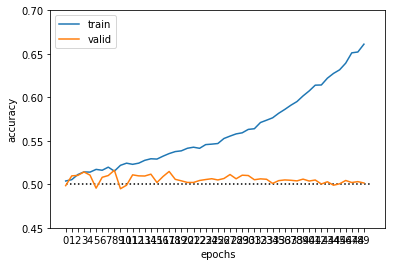

In [48]:
# results using training set and valid set 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.hlines(0.5, 0, 50, linestyles='dotted')
plt.ylim(0.45, 0.70)
plt.xticks(range(0, 50))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'valid']);

In [36]:
print(model.evaluate(X_test, y_test, verbose=1))

12833/12833 [==============================] - 2s 124us/step
[0.7347037167316158, 0.5051819527779943]


In [0]:
pred = model.predict(X_test)

In [51]:
pred[:10, :]

array([[0.23070341, 0.7692965 ],
       [0.76599735, 0.23400263],
       [0.15451215, 0.84548783],
       [0.65897965, 0.34102032],
       [0.43953037, 0.5604696 ],
       [0.28754872, 0.7124513 ],
       [0.63702834, 0.36297172],
       [0.32686573, 0.67313427],
       [0.9607487 , 0.03925136],
       [0.604691  , 0.395309  ]], dtype=float32)

In [0]:
# pred_probs = pd.Series(pred[:, 1], name = "pred_probs")

results = pd.concat([pd.Series(pred[:, 1], name = "pred_probs"), pd.Series(y_test[:, 1], name='label')], axis = 1)

In [0]:
results['pred_prob_level'] = [int(x * 20)/20 for x in results['pred_probs']]

In [62]:
summary = pd.concat([results.groupby(['pred_prob_level']).mean(), 
                     results.groupby(['pred_prob_level']).count()['label'], 
                     100 * results.groupby(['pred_prob_level']).count()['label']/results.shape[0]], 
                    axis = 1)
summary.columns = ['predicted win prob', 'actual win rate', '# of trades', '% of all trades']
summary

,predicted win prob,actual win rate,# of trades,% of all trades
pred_prob_level,,,,
0.00,0.030699,0.438776,98,0.763656
0.05,0.077011,0.532051,156,1.215616
0.10,0.126056,0.521739,207,1.613029
0.15,0.176061,0.484642,293,2.283176
0.20,0.225739,0.503704,405,3.155926
0.25,0.276661,0.517578,512,3.989714
0.30,0.326478,0.506438,699,5.446895
0.35,0.375568,0.497712,874,6.810567
0.40,0.425807,0.498513,1009,7.862542
